In [4]:
import os
import json
from read_data import Reader
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
tf.random.set_seed(3)


def make_dataset():
    """
    To make tf.data.Dataset for training and test_x, test_y for testing and evaluation.
    :return: train_dataset, val_dataset, test_features, test_labels
    """
    reader = Reader()
    with open(os.path.join(r'E:\rainfall\rainforday\model\config.json'), 'r') as json_file:
        config = json.load(json_file)

    features = config['features']
    train = reader.read_many('train', features)
    val = reader.read_many('val', features)
    test = reader.read_many('test', features)

    train_mean = train.mean(axis=0)['RPH']
    train_std = train.std(axis=0)['RPH']

    def normalization(dataframe):
        return (dataframe - train.mean(axis=0)) / train.std(axis=0)

    def dataframe_to_dataset(dataframe, shuffle=True, repeat=True, batch_size=32):
        dataframe = dataframe.copy()
        labels = dataframe.pop('RPH')
        dataset = tf.data.Dataset.from_tensor_slices((dataframe, labels))
        if shuffle:
            dataset = dataset.shuffle(buffer_size=len(dataframe))
        dataset = dataset.batch(batch_size)
        if repeat:
            dataset = dataset.repeat()
        return dataset

    train, val, test = normalization(train), normalization(val), normalization(test)
    train_dataset = dataframe_to_dataset(train)
    val_dataset = dataframe_to_dataset(val, shuffle=False)
    test_labels = test.pop('RPH')
    test_features = test
    return train_dataset, val_dataset, test_features, test_labels, train_mean, train_std


def dense_model_sequential_1():
    """
    To make a model in a sequential way (way 1).
    Performs exactly the same as the two methods below.
    :return: Model established
    """
    model = tf.keras.Sequential()
    model.add(layers.Dense(9, activation='sigmoid'))
    model.add(layers.Dense(45, activation='sigmoid'))
    model.add(layers.Dense(1))

    optimizer = tf.keras.optimizers.Adam(
        learning_rate=0.01
    )
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])

    return model


def dense_model_sequential_2():
    """
    To make a model in a sequential way (way 2).
    :return: Model established.
    """
    model = tf.keras.Sequential([
        layers.Dense(7, activation='sigmoid'),
        layers.Dense(25, activation='sigmoid'),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(
        learning_rate=0.01
    )
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])

    return model


def dense_model_functional():
    """
    To make a model in a functional way, recommended.
    :return: Model established.
    """
    x = layers.Input(7)
    d = layers.Dense(7, activation='sigmoid')(x)
    d = layers.Dense(25, activation='sigmoid')(d)
    d = layers.Dense(1)(d)

    model = tf.keras.Model(inputs=x, outputs=d)
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=0.01
    )
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])

    return model


Epoch 1/200

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

65/65 [==============================] - 0s 4ms/step - loss: 1.0441 - mae: 0.6009 - mse: 1.0441 - val_loss: 1.0034 - val_mae: 0.5604 - val_mse: 1.0034
Epoch 2/200
65/65 [==============================] - 0s 1ms/step - loss: 0.4546 - mae: 0.3231 - mse: 0.4546 - val_loss: 0.5336 - val_mae: 0.2503 - val_mse: 0.5336
Epoch 3/200
65/65 [==============================] - 0s 1ms/step - loss: 0.2829 - mae: 0.2225 - mse: 0.2829 - val_loss: 0.4359 - val_mae: 0.2371 - val_mse: 0.4359
Epoch 4/200
65/65 [

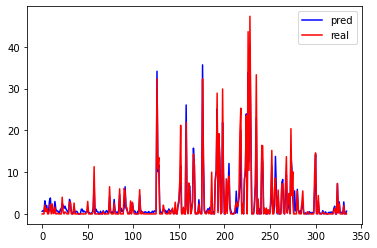

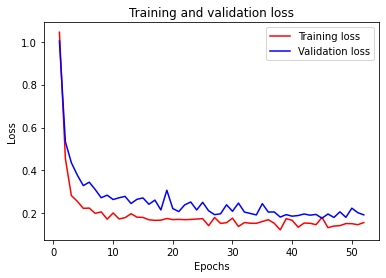

Average daily rainfall in 2020 - real :  2.817611940298508
Average daily rainfall in 2020 - pred:  2.7112591
real is bigger than pred by:  0.03922635523451054 

Average daily rainfall in 202007-09 - real : 2.1363207547169814
Average daily rainfall in 202007-09 - pred : 2.2529469
real is bigger than pred by : -0.05176602312318417 

Average daily rainfall in 202008-11 - real : 4.009836065573769
Average daily rainfall in 202008-11 - pred : 3.5114276
real is bigger than pred by : 0.14193897059174176 



In [5]:

    epochs = 200
    size_train, size_val = 2091, 713  #for every day 2020
    # size_train, size_val = 1726, 723  #for every day 2019
    # size_train, size_val = 57, 23    #for month
    batch_size = 32  #4
    train_ds, val_ds, test_x, test_y, train_mean, train_std = make_dataset()
    model = dense_model_sequential_1()
    # model = dense_model_sequential_2()
    # model = dense_model_functional()
    callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=0, patience=7, verbose=0,
        mode='auto', baseline=None, restore_best_weights=True
    )
    history = model.fit(train_ds, epochs=epochs, steps_per_epoch=size_train // batch_size,
                        validation_data=val_ds, validation_steps=size_val // batch_size,
                        callbacks=[callback])
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    print(model.summary())
    # if not os.path.exists('model'):
    #     os.makedirs('model')
    # model.save('model')
    # model = tf.keras.models.load_model('model')
    pred_y = model.predict(test_x)
    pred_y = pred_y * train_std + train_mean
    test_y = test_y * train_std + train_mean
    for index in range(len(pred_y)):
         if pred_y[index]<0:
            pred_y[index]=0


    # paint pred and real
    # x = range(355)  #for day 2019
    x = range(335)  #for day 2020
    # x = range(1,12)  #for month
    plt.plot(x, pred_y, label="pred",color='b')
    plt.plot(x, test_y, label="real",color='r')
    plt.legend()
    plt.show()
    plt.close()

    #paint loss and accuracy
    history_dict = history.history
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    plt.close()





    #result
    print("Average daily rainfall in 2020 - real : ",test_y.mean())
    print("Average daily rainfall in 2020 - pred: ",pred_y.mean())
    print("real is bigger than pred by: ",(test_y.mean()-pred_y.mean())/pred_y.mean(),"\n")
    # test_half1 = test_y[:212] #2019
    # test_half2 = test_y[212:]
    # pred_half1 = pred_y[:212]
    # pred_half2 = pred_y[212:]
    test_half1 = test_y[:212]   #2020
    test_half2 = test_y[213:]
    pred_half1 = pred_y[:213]
    pred_half2 = pred_y[213:]
    # test_half1 = test_y[:7]
    # test_half2 = test_y[7:]
    # pred_half1 = pred_y[:7]
    # pred_half2 = pred_y[7:]
    print("Average daily rainfall in 202007-09 - real :",test_half1.mean())
    print("Average daily rainfall in 202007-09 - pred :",pred_half1.mean())
    print("real is bigger than pred by :",(test_half1.mean()-pred_half1.mean())/pred_half1.mean(),'\n')

    print("Average daily rainfall in 202008-11 - real :",test_half2.mean())
    print("Average daily rainfall in 202008-11 - pred :",pred_half2.mean())
    print("real is bigger than pred by :",(test_half2.mean()-pred_half2.mean())/pred_half2.mean(),"\n")


In [44]:
pre=pred_y.reshape(335,)
test_y-pre

0     -0.626565
1     -0.778613
2     -0.537804
3     -1.032765
4     -1.074652
         ...   
330   -0.026674
331   -0.875591
332   -0.015371
333    0.080692
334   -0.649755
Name: RPH, Length: 335, dtype: float64

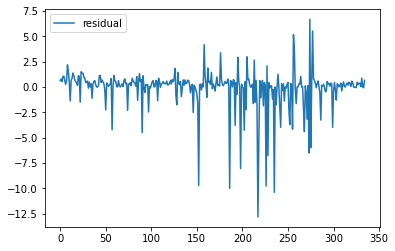

In [46]:
    #paint Residual plot
    x=range(335)
    pre=pred_y.reshape(335,)
    residual = pre - test_y
    plt.plot(x,residual, label="residual")
    plt.legend()
    plt.show()
    plt.close()